# 도로영역 세그멘테이션 모델 만들기

## 1. 이미지, 데이터 가져오기
* KITTI 데이터셋의 세그멘테이션 데이터 사용

```
$mkdir -p ~/aiffel/semantic_segmentation/data
$ln -s ~/data/* ~/aiffel/semantic_segmentation/data/
```

## 2. 데이터 로더(data loader) 만들기
* 모델을 학습시킬 수 있는 데이터 로더(data loader) 만들기
* 입력값 (224, 224), 출력값(224,224) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야 한다.
* 이 때 데이터 로더에 augmentation을 적용시킨다 : albumentations 모듈
* 또한 학습셋의 일정량을 검증 데이터셋(validation dataset)으로 활용할 수 있도록 해야 한다.

In [70]:
# 필요한 라이브러리 로드
import os
import math
import numpy as np
import tensorflow as tf
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

### (1) Albumentation 사용법
* Albumentation에서 다양한 augmentation 기법을 확률적으로 사용할 수 있게 해주는 Compose()의 활용예이다.
* imgaug의 Sometimes()와 유사한 기능

In [71]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

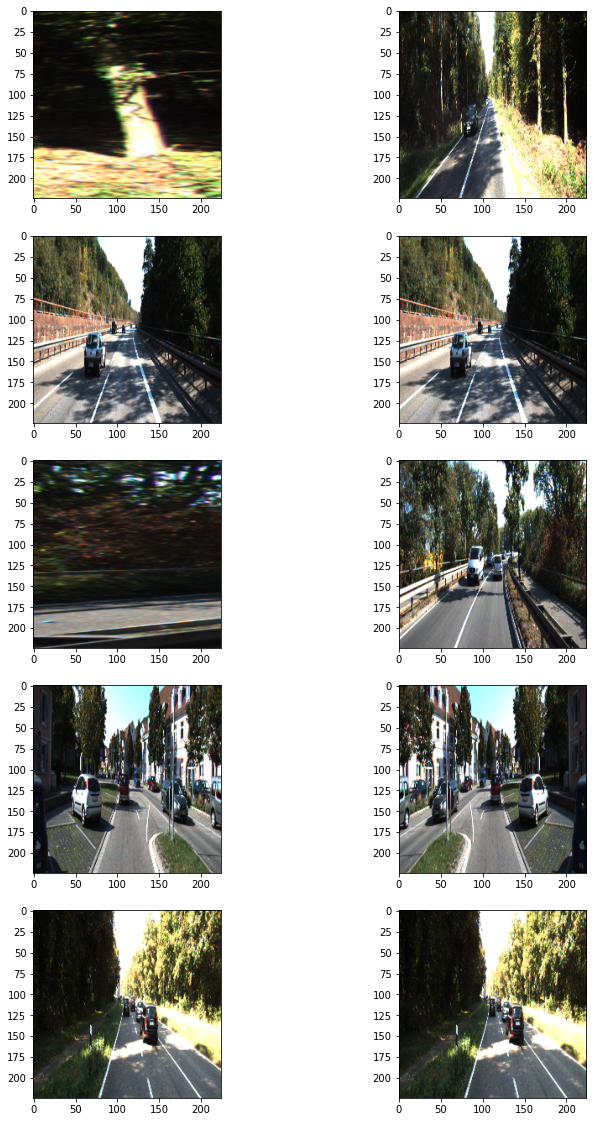

In [72]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

### 데이터셋 구성
* tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성한다.

In [73]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                    "image": _input,
                    "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [74]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 3. 시맨틱 세그멘테이션 모델
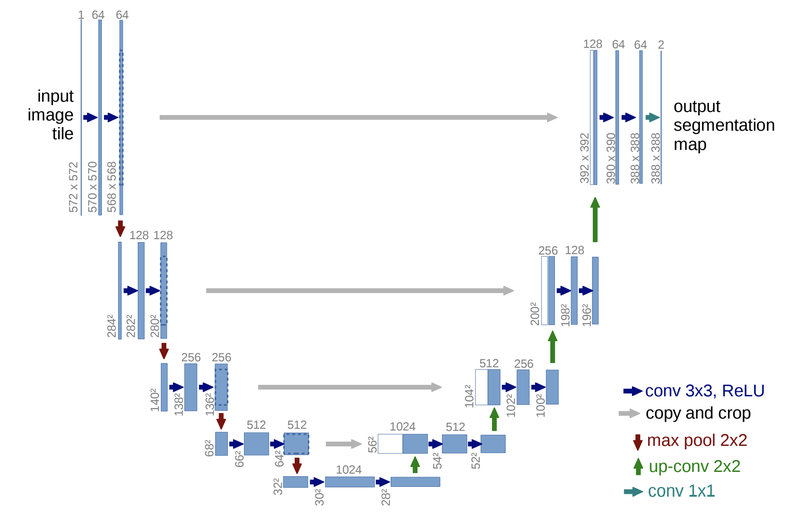
### (1) 모델 구조 만들기
* 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만든다.
* 사용에 필요한 레이어와 연산은 다음과 같다. 필요에 따라서 Dropout 등의 다른 레이어를 적용한다.
  * Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

In [75]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
      
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
      
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

### (2) 모델 학습하기
* 적절한 learning rate와 epoch를 찾아 모델을 학습하고 저장한다.

In [76]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation'

model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path + '/seg_model_unet.h5')  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 14s 1s/step - loss: 0.6880 - val_loss: 0.6611
Epoch 2/100
11/11 [==============================] - 12s 1s/step - loss: 0.5355 - val_loss: 0.1244
Epoch 3/100
11/11 [==============================] - 12s 1s/step - loss: 0.1066 - val_loss: 0.0373
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 0.0370 - val_loss: 0.0355
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 0.0312 - val_loss: 0.0338
Epoch 6/100
11/11 [==============================] - 12s 1s/step - loss: 0.0289 - val_loss: 0.0380
Epoch 7/100
11/11 [==============================] - 12s 1s/step - loss: 0.0366 - val_loss: 0.0312
Epoch 8/100
11/11 [==============================] - 12s 1s/step - loss: 0.0358 - val_loss: 0.0327
Epoch 9/100
11/11 [==============================] - 12s 1s/step - loss: 0.0287 - val_loss: 0.0317
Epoch 10/100
11/11 [==============================] - 12s 1s/step - loss: 0.0293 - val_loss: 0.0323
Epoch 11/

11/11 [==============================] - 12s 1s/step - loss: 0.0160 - val_loss: 0.0222
Epoch 84/100
11/11 [==============================] - 12s 1s/step - loss: 0.0142 - val_loss: 0.0201
Epoch 85/100
11/11 [==============================] - 12s 1s/step - loss: 0.0146 - val_loss: 0.0211
Epoch 86/100
11/11 [==============================] - 12s 1s/step - loss: 0.0142 - val_loss: 0.0207
Epoch 87/100
11/11 [==============================] - 12s 1s/step - loss: 0.0155 - val_loss: 0.0272
Epoch 88/100
11/11 [==============================] - 12s 1s/step - loss: 0.0213 - val_loss: 0.0230
Epoch 89/100
11/11 [==============================] - 12s 1s/step - loss: 0.0184 - val_loss: 0.0220
Epoch 90/100
11/11 [==============================] - 12s 1s/step - loss: 0.0168 - val_loss: 0.0232
Epoch 91/100
11/11 [==============================] - 12s 1s/step - loss: 0.0180 - val_loss: 0.0214
Epoch 92/100
11/11 [==============================] - 12s 1s/step - loss: 0.0159 - val_loss: 0.0220
Epoch 93/100


### (3) 학습된 모델 가져오기
* 학습된 모델을 가져올 수도 있다.

In [ ]:
# 미리 준비한 모델을 불러오기
# model_path = dir_path + '/seg_model_unet.h5' 

# model = tf.keras.models.load_model(model_path)

## 4. 모델 예측 결과 평가
* 시각화를 통한 정성적 비교
  * 모델이 추론한 결과를 눈으로 볼 수 있는 세그멘테이션 이미지로 만든다.
  * 이 때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(Overray)를 활용한다. -> PIL 패키지의 Image.blend
* IoU 계산을 통한 정량적 비교
  * prediction : 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬
  * target : 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬
  * 위에 구현했던 get_output을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현

### (1) 정성적 평가
* image를 blend한 결과를 정성적으로 평가하기 위해 시각화

In [94]:
def get_output_quality(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    
    # output image와 origin image blend하는 함수
    output = Image.fromarray(output)    # 예측 결과
    background = Image.fromarray(origin_img).convert('RGBA')    # 기존 이미지
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')    # output 이미지를 origin image의 크기와 같게 변환
    output = Image.blend(background, output, alpha=0.5) # 이미지 합성
    output.show()
    return output 

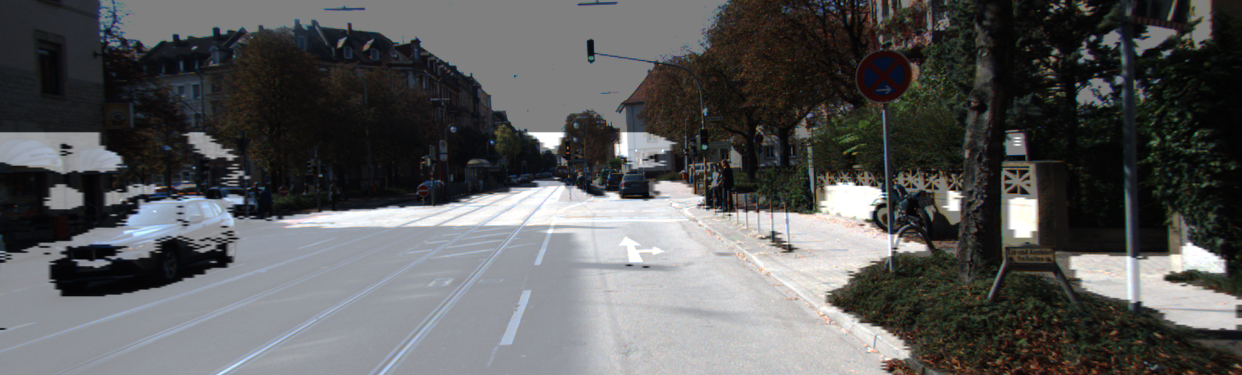

In [79]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output_quality(
    model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
)

### (2) 정량적 평가
* 정량적 평가를 위한 IoU(Intersection over Union)를 계산한다.

In [41]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [95]:
def get_output_quantity(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [96]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output_quantity(
    model, 
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

calculate_iou_score(target, prediction)

IoU : 0.726501


0.7265006979990694

# Project : 개선된 U-Net 모델 만들기
* 앞서 학습한 U-Net의 결과를 살펴봤을 때 그림자로 인해 어두워진 영역은 제대로 학습해내지 못했다.
* 또한 하늘이나 인도를 도로라고 예측하는 등 학습 결과가 좋지 않았다.
* IoU를 살펴보았을 때도 0.42정도로 매우 낮은 학습결과를 보인다.

## U-Net++
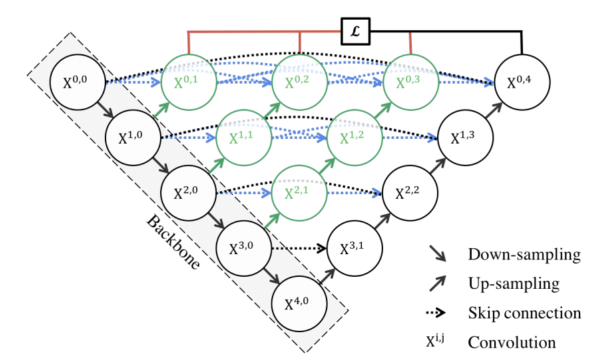
* 기존 Segmentation 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델이다.

In [45]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### 1. U-Net++ 모델 구축
* U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델

In [46]:
def build_unet_pp(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # X0,0
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_0)
    pool0_0 = MaxPooling2D(pool_size=(2,2))(conv0_0)
    
    # X1,0
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool0_0)
    conv1_0 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_0)
    pool1_0 = MaxPooling2D(pool_size=(2,2))(conv1_0)

    # X2,0
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1_0)
    conv2_0 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_0)
    pool2_0 = MaxPooling2D(pool_size=(2,2))(conv2_0)
    
    # X3,0
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2_0)
    conv3_0 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_0)
    pool3_0 = MaxPooling2D(pool_size=(2,2))(conv3_0)
    
    # X4,0
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3_0)
    conv4_0 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_0)    
    
    # X0,1
    up1_0 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_0)
    merge0_1 = concatenate([up1_0, conv0_0], axis = 3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_1)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_1)
    
    # X1,1
    up2_0 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_0)
    merge1_1 = concatenate([up2_0, conv1_0], axis = 3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_1)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_1)
    
    # X2,1
    up3_0 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_0)
    merge2_1 = concatenate([up3_0, conv2_0], axis = 3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_1)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_1)
    
    # X3,1
    up4_0 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_0)
    merge3_1 = concatenate([up4_0, conv3_0], axis = 3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3_1)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_1)
    
    
    # X0,2
    up1_1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_1)
    merge0_2 = concatenate([up1_1, conv0_0, conv0_1], axis=3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_2)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_2)
    
    # X1,2
    up2_1 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
    merge1_2 = concatenate([up2_1, conv1_0, conv1_1], axis=3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_2)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_2)
    
    # X2,2
    up3_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_1)
    merge2_2 = concatenate([up3_1, conv2_0, conv2_1], axis=3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_2)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_2)
    
    
    # X0,3
    up1_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_2)
    merge0_3 = concatenate([up1_2, conv0_0, conv0_1, conv0_2], axis=3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_3)
    
    # X1,3
    up2_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_2)
    merge1_3 = concatenate([up2_2, conv1_0, conv1_1, conv1_2], axis=3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_3)
    
    
    # X0,4
    up1_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv1_3)
    merge0_4 = concatenate([up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis=3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_4)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_4)
    
    
    output = Conv2D(1, 1, activation='sigmoid')(conv0_4)
    model = Model(inputs = inputs, outputs = output)
    
    return model

In [47]:
unet_pp = build_unet_pp()
unet_pp.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_111 (Conv2D)             (None, 224, 224, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 224, 224, 64) 36928       conv2d_111[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_112[0][0]                 
____________________________________________________________________________________________

In [48]:
unet_pp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet_pp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100
)

unet_pp_path = model_path + '/seg_model_unet_pp.h5'
unet_pp.save(unet_pp_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 67s 2s/step - loss: 0.6031 - val_loss: 0.1151
Epoch 2/100
43/43 [==============================] - 64s 1s/step - loss: 0.1260 - val_loss: 0.0865
Epoch 3/100
43/43 [==============================] - 65s 2s/step - loss: 0.1030 - val_loss: 0.0969
Epoch 4/100
43/43 [==============================] - 65s 2s/step - loss: 0.0842 - val_loss: 0.0741
Epoch 5/100
43/43 [==============================] - 64s 2s/step - loss: 0.0647 - val_loss: 0.0643
Epoch 6/100
43/43 [==============================] - 64s 1s/step - loss: 0.0814 - val_loss: 0.0945
Epoch 7/100
43/43 [==============================] - 64s 1s/step - loss: 0.0604 - val_loss: 0.0657
Epoch 8/100
43/43 [==============================] - 64s 1s/step - loss: 0.0578 - val_loss: 0.0688
Epoch 9/100
43/43 [==============================] - 64s 1s/step - loss: 0.0733 - val_loss: 0.0646
Epoch 10/100
43/43 [==============================] - 64s 1s/step - loss: 0.0866 - val_loss: 0.0780
Epoch 11/

43/43 [==============================] - 64s 1s/step - loss: 0.0321 - val_loss: 0.0747
Epoch 84/100
43/43 [==============================] - 64s 1s/step - loss: 0.0455 - val_loss: 0.0519
Epoch 85/100
43/43 [==============================] - 64s 1s/step - loss: 0.0382 - val_loss: 0.0425
Epoch 86/100
43/43 [==============================] - 64s 1s/step - loss: 0.0359 - val_loss: 0.0436
Epoch 87/100
43/43 [==============================] - 64s 1s/step - loss: 0.0421 - val_loss: 0.0500
Epoch 88/100
43/43 [==============================] - 64s 1s/step - loss: 0.0323 - val_loss: 0.0505
Epoch 89/100
43/43 [==============================] - 64s 1s/step - loss: 0.0315 - val_loss: 0.0526
Epoch 90/100
43/43 [==============================] - 64s 1s/step - loss: 0.0314 - val_loss: 0.0497
Epoch 91/100
43/43 [==============================] - 64s 1s/step - loss: 0.0299 - val_loss: 0.0422
Epoch 92/100
43/43 [==============================] - 64s 1s/step - loss: 0.0319 - val_loss: 0.0478
Epoch 93/100


### 2. Segmentation 결과 비교

In [80]:
unet_path = model_path + '/seg_model_unet.h5'
unet_pp_path = model_path + '/seg_model_unet_pp.h5'

unet= tf.keras.models.load_model(unet_path)
unet_pp = tf.keras.models.load_model(unet_pp_path)

#### (1) 정성적 평가

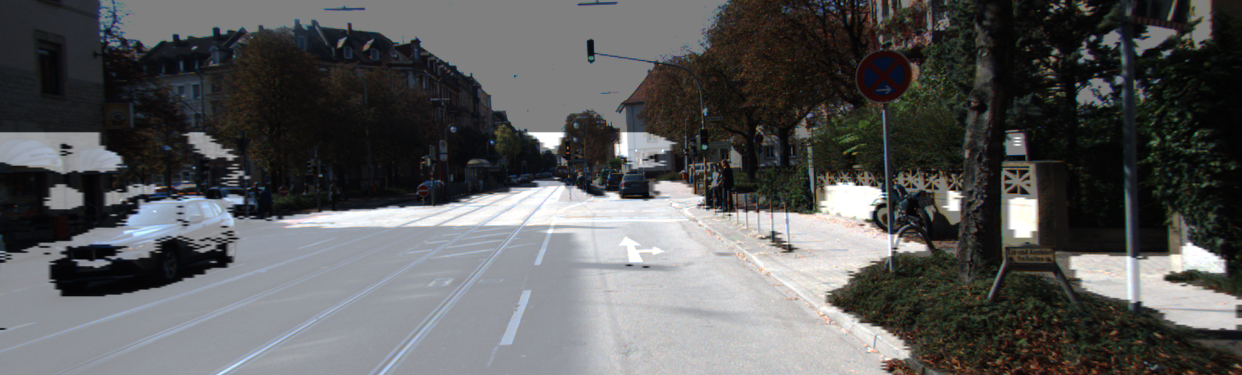

In [82]:
# U-Net 추론 결과 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output_quality(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

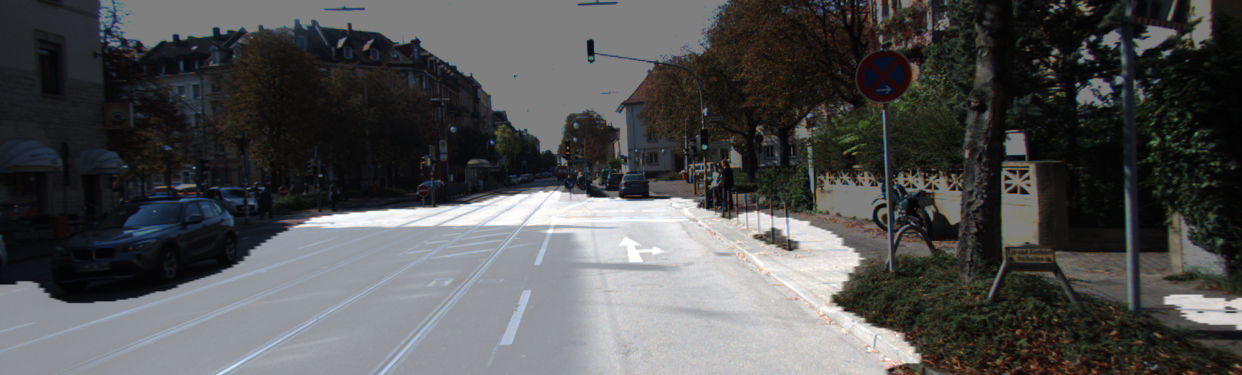

In [83]:
# U-Net++ 추론 결과 시각화
get_output_quality(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

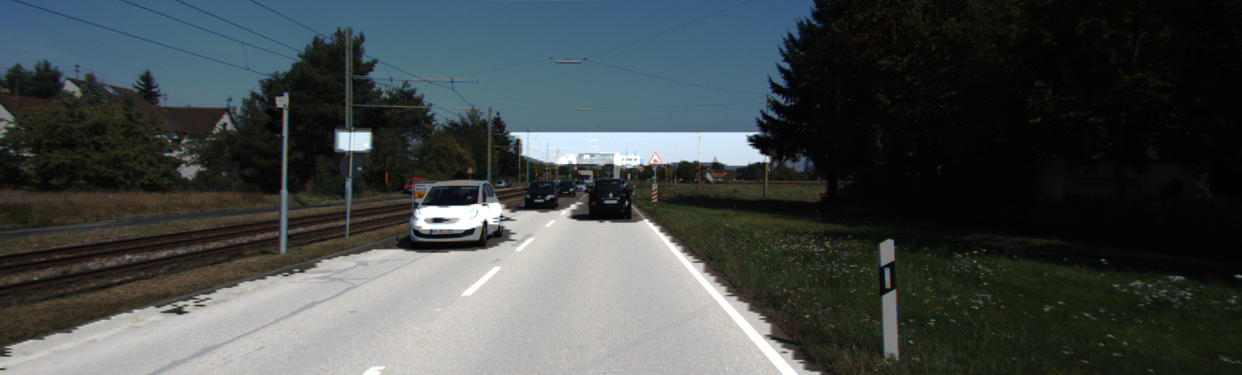

In [100]:
# U-Net 추론 결과 시각화
i = 36    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output_quality(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

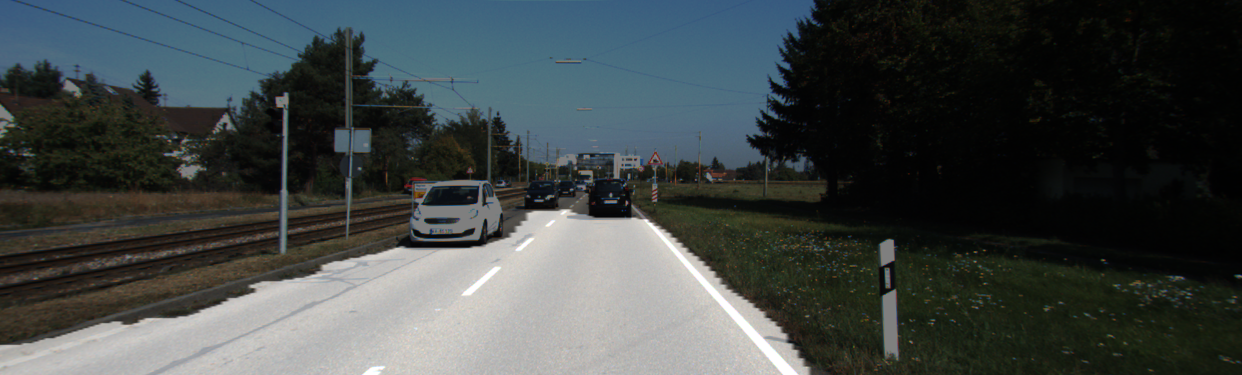

In [101]:
# U-Net++ 추론 결과 시각화
get_output_quality(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

#### (2) 정량적 평가

In [88]:
unet_iou = []
unet_pp_iou = []

for i in range(50):  # 이미지 50개로 테스트
    # U-Net의 IoU 계산
    output, prediction, target = get_output_quantity(
         unet, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_iou.append(calculate_iou_score(target, prediction))

    # U-Net++의 IoU 계산
    output, prediction, target = get_output_quantity(
         unet_pp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    unet_pp_iou.append(calculate_iou_score(target, prediction))

IoU : 0.731965
IoU : 0.862343
IoU : 0.726501
IoU : 0.855245
IoU : 0.474010
IoU : 0.611706
IoU : 0.599962
IoU : 0.595884
IoU : 0.426276
IoU : 0.678183
IoU : 0.400199
IoU : 0.737207
IoU : 0.267955
IoU : 0.485913
IoU : 0.649761
IoU : 0.856363
IoU : 0.724692
IoU : 0.850316
IoU : 0.708657
IoU : 0.776141
IoU : 0.692913
IoU : 0.700143
IoU : 0.683506
IoU : 0.792230
IoU : 0.640711
IoU : 0.742418
IoU : 0.851209
IoU : 0.790888
IoU : 0.844681
IoU : 0.817936
IoU : 0.852050
IoU : 0.821316
IoU : 0.853334
IoU : 0.825891
IoU : 0.824132
IoU : 0.874035
IoU : 0.687762
IoU : 0.776066
IoU : 0.737853
IoU : 0.870712
IoU : 0.691053
IoU : 0.790994
IoU : 0.470531
IoU : 0.693554
IoU : 0.836573
IoU : 0.810473
IoU : 0.755511
IoU : 0.833807
IoU : 0.629510
IoU : 0.666118
IoU : 0.570211
IoU : 0.574577
IoU : 0.539711
IoU : 0.535920
IoU : 0.688880
IoU : 0.779257
IoU : 0.634976
IoU : 0.849402
IoU : 0.543592
IoU : 0.785798
IoU : 0.611192
IoU : 0.739611
IoU : 0.574634
IoU : 0.800000
IoU : 0.591546
IoU : 0.705646
IoU : 0.67

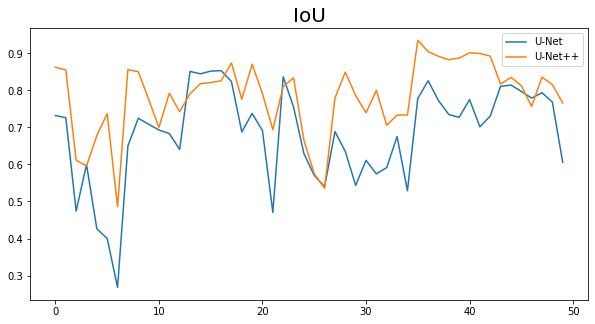

In [91]:
plt.figure(figsize=(10,5))
plt.plot(unet_iou)
plt.plot(unet_pp_iou)
plt.title('IoU', fontsize=20)
plt.legend(['U-Net', 'U-Net++'])
plt.show()

In [92]:
# IoU 평균 비교
df_iou = pd.DataFrame({'U-Net': unet_iou,
                       'U-Net++': unet_pp_iou})
df_iou.mean()

U-Net      0.682737
U-Net++    0.783744
dtype: float64

# 결과 정리
#### U-Net++ 구현
* 논문의 이미지를 참고해 Conv2D, MaxPooling2D, UpSampling2D, concatenate를 사용해 한 단계씩 구현했다.
* BatchNormalization이나 Dropout을 적절히 활용하면 성능을 더 높일 수 있을 것 같다.
* U-Net++는 U-Net보다 메모리 사용량이 많아 모델을 학습시킬 때 OOM에러가 발생하므로 학습 데이터의 batch size를 4로 줄였다.

#### 시각화 결과 비교
* segmentation 결과를 시각화 하여 육안으로 봤을 때 U-Net의 경우 도로 뿐만 아니라 차량, 인도, 하늘까지 도로로 인식하는 모습을 보인다.
* U-Net++의 경우에는 일부 인도를 인식하는 결과를 보이지만, 전체적으로 도로객체를 정확하게 인식했다.
* 36번 이미지의 경우에는 도로객체 자체는 U-Net++보다 정확하게 인식해냈다. 하지만 하늘 역시 인식하면서 정확도에서는 U-Net++보다 낮은 결과를 보인다.
* U-Net++의 경우에는 도로객체만을 인식해내긴 했지만 일부 도로를 인식하지 못한 모습을 보인다.

#### IoU비교
* 전체적으로 비교해보기 위해 이미지 50개에 대한 두 모델의 IoU를 각각 계산하여 비교해 보았다.
* IoU를 시각화해본 결과 U-Net++의 수치가 대체적으로 더 높은 것을 알 수 있었다.
* 평균 IoU 역시 U-Net이 0.68, U-Net++가 0.78로 U-Net++의 성능이 더욱 우수한 것을 확인할 수 있다.